### Based on Algorithm 4 in http://arxiv.org/pdf/1307.1827v7.pdf

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors.kde import KernelDensity
from sklearn.cross_validation import train_test_split
import pandas as pd
from sklearn.linear_model import Ridge
import seaborn as sns
from __future__ import division
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.covariance import empirical_covariance

In [355]:
from __future__ import division

class Heavy_tail_ridge(Ridge):
    def __init__(self, alpha=1.0, fit_intercept=True, normalize=False,
                 copy_X=True, max_iter=None, tol=1e-3, solver="auto",
                 random_state=None, delta = 0.2, c = 5):
        
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol
        self.solver = solver
        self.random_state = random_state
        self.delta = delta
        self.c = c
        self.models = []
        self.num_of_samples = 0
        self.coef_ = []
        
        
    def fit(self,X,y):
        model_w_vectors = []
        covariance_factor = []
        medians = []
        w = []
        ridge = Ridge(self.alpha, self.fit_intercept, self.normalize,
                 self.copy_X, self.max_iter, self.tol, self.solver,
                 self.random_state)
        self.num_of_samples = np.ceil(self.c * np.log(1/self.delta))
        #self.num_of_samples = 7
        X_samples, y_samples = self._get_samples(X,y,self.num_of_samples)
        sample_size = np.floor(X.shape[0]/self.num_of_samples)
        
        for i in range(len(X_samples)):
            clf = ridge.fit(X_samples[i],y_samples[i])
            self.models.append(clf)
            model_w_vectors.append(self.models[i].coef_)
        
        sigma_cov = []
        for i in range(len(X_samples)):
            sigma_cov.append(empirical_covariance(X_samples[i]))
        #covariance_factor.append((1/(X_samples[i].shape[0])) * (np.vdot(X_samples[i],X_samples[i])))
        for i in range(len(self.models)):
            dist_list = []
            for j in range(len(self.models)):
                if (i == j):
                    continue
                else:
                    dv = model_w_vectors[i] - model_w_vectors[j]
                    distance = np.dot(dv,np.dot((sigma_cov[j] + np.eye(X.shape[1])*self.alpha),dv.T))
                    '''
                    cov = covariance_factor[j] + self.alpha
                    distance = cov * np.vdot(distance_vector,distance_vector)
                    '''
                    dist_list.append(distance)
            medians.append(np.median(dist_list))
                    
        least_median_idx = np.argmin(medians)
        self.coef_ = np.array(model_w_vectors[least_median_idx])
        return self
    
    def predict(self,X):
        res = np.dot(self.coef_,X.T)
        return np.array(res[0])
    
    def _get_samples(self,X,y,num_of_samples):
        X, y = self._shuffle_data(X,y)
        instances = y.shape[0]
        extras = instances % num_of_samples
        if (extras != 0):
            X = X[:instances - extras,:]
            y = y[:instances - extras,:]
        return np.split(X,num_of_samples), np.split(y,num_of_samples)
        
    def _shuffle_data(self,X,y):
        permutation = np.random.permutation(X.shape[0])
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]
        return X_shuffled,y_shuffled
    
    
    def score(self, X, y, sample_weight=None):
        r,c = y.shape
        y_pred = self.predict(X)
        y = y.reshape(y_pred.shape)
        J = np.abs(y - y_pred)
        threshold = 0.25
        threshold_matrix = np.true_divide(J,y)
        for i in range(0,r):
            if (threshold_matrix[i] <= 0):
                J[i] = 0
            else:
                J[i] = threshold_matrix[i] - 0
        norm = np.linalg.norm(J)
        loss = np.square(norm) / (2*r)
        return -loss
        

### Experiments with sample data generated

In [3]:
mu, sigma = 0, 1.

In [24]:
#Generating design matrix

X1 = np.random.normal(mu,sigma,300).reshape(100,3)
X2 = np.random.normal(mu,sigma,3000).reshape(1000,3)
X3 = np.random.normal(mu,sigma,6000).reshape(2000,3)
X4 = np.random.normal(mu,sigma,15000).reshape(5000,3)
X5 = np.random.normal(mu,sigma,21000).reshape(7000,3)
X6 = np.random.normal(mu,sigma,54000).reshape(18000,3)
X7 = np.random.normal(mu,sigma,105000).reshape(35000,3)

In [25]:
y2 = np.random.lognormal(mu, sigma, 1000)
y3 = np.random.lognormal(mu, sigma, 2000)
y4 = np.random.lognormal(mu, sigma, 5000)
y5 = np.random.lognormal(mu, sigma, 7000)
y6 = np.random.lognormal(mu, sigma, 18000)
y7 = np.random.lognormal(mu, sigma, 35000)
y1 = np.random.lognormal(mu, sigma, 100)


In [26]:
y1 = np.reshape(y1,(y1.shape[0],1))
y2 = np.reshape(y2,(y2.shape[0],1))
y3 = np.reshape(y3,(y3.shape[0],1))
y4 = np.reshape(y4,(y4.shape[0],1))
y5 = np.reshape(y5,(y5.shape[0],1))
y6 = np.reshape(y6,(y6.shape[0],1))
y7 = np.reshape(y7,(y7.shape[0],1))



In [27]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size =0.3, random_state=5)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size =0.3, random_state=5)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size =0.3, random_state=5)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size =0.3, random_state=5)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size =0.3, random_state=5)
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size =0.3, random_state=5)
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7, test_size =0.3, random_state=5)

<IPython.core.display.Javascript object>


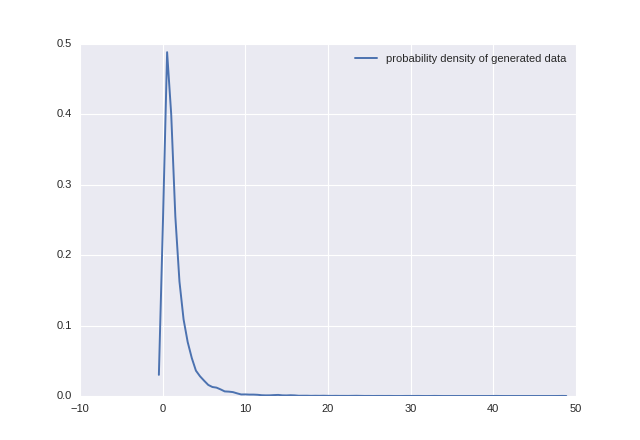

In [28]:
plt.close()
sns.distplot(y7_test,hist=False,label='probability density of generated data')

In [282]:
pipe = Pipeline([
    ('heavy_tail', Heavy_tail_ridge()),
])

parameters = {
    'heavy_tail__alpha': (0.00001, 0.001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000, 100000 ),
    'heavy_tail__delta': (0.1,0.2,0.3,0.4)
}

grid_search = GridSearchCV(pipe, parameters, n_jobs=-1, verbose=1, cv = 10)

In [283]:
gr1 = grid_search.fit(X1_train,y1_train)
'''
gr2 = grid_search.fit(X2_train,y2_train)
gr3 = grid_search.fit(X3_train,y3_train)
gr4 = grid_search.fit(X4_train,y4_train)
gr5 = grid_search.fit(X5_train,y5_train)
gr6 = grid_search.fit(X6_train,y6_train)
gr7 = grid_search.fit(X7_train,y7_train)
'''


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.7s finished


Fitting 10 folds for each of 40 candidates, totalling 400 fits


'\ngr2 = grid_search.fit(X2_train,y2_train)\ngr3 = grid_search.fit(X3_train,y3_train)\ngr4 = grid_search.fit(X4_train,y4_train)\ngr5 = grid_search.fit(X5_train,y5_train)\ngr6 = grid_search.fit(X6_train,y6_train)\ngr7 = grid_search.fit(X7_train,y7_train)\n'

In [284]:
print gr1.best_params_ 
print gr2.best_params_ 
print gr3.best_params_ 
print gr4.best_params_ 
print gr5.best_params_ 
print gr6.best_params_ 
print gr7.best_params_ 

{'heavy_tail__delta': 0.1, 'heavy_tail__alpha': 10}
{'heavy_tail__delta': 0.1, 'heavy_tail__alpha': 1e-05}
{'heavy_tail__delta': 0.1, 'heavy_tail__alpha': 1e-05}
{'heavy_tail__delta': 0.1, 'heavy_tail__alpha': 1e-05}
{'heavy_tail__delta': 0.1, 'heavy_tail__alpha': 1e-05}
{'heavy_tail__delta': 0.1, 'heavy_tail__alpha': 1e-05}
{'heavy_tail__delta': 0.1, 'heavy_tail__alpha': 1e-05}


In [285]:
s1 = gr1.best_score_
s2 = gr2.best_score_
s3 = gr3.best_score_
s4 = gr4.best_score_
s5 = gr5.best_score_
s6 = gr6.best_score_
s7 = gr7.best_score_

In [287]:
print s1,s2,s3,s4,s5,s6,s7

-0.306317790483 0.0 0.0 0.0 0.0 0.0 0.0


In [288]:
from sklearn.learning_curve import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(Heavy_tail_ridge(), X7, y7, train_sizes=[500,1000,2000,7000], cv=10)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


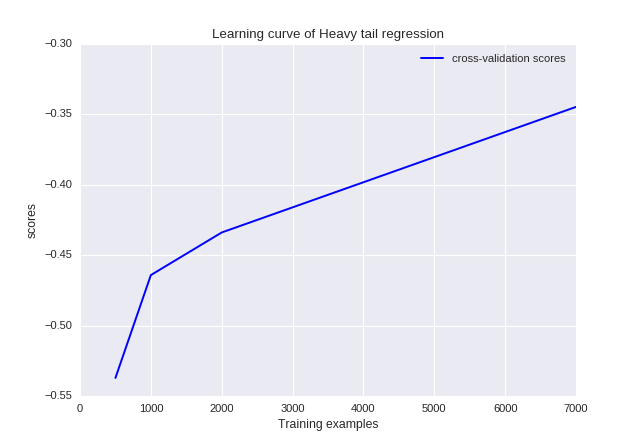

In [280]:
plt.close()
plt.title("Learning curve of Heavy tail regression")
plt.xlabel("Training examples")
plt.ylabel("scores")
plt.plot(train_sizes,valid_scores.mean(axis = 1),'b', label = "cross-validation scores")
plt.legend()

In [295]:
pred = gr1.predict(X2_test)
print gr1.score(X2_test,y2_test)

-0.45483444429


### with Real Salary data

In [296]:
plt.close()
df = pd.read_csv("DesignMatrix.csv")
input = df.as_matrix()
X = input[:,1:-1]
Y = input[:,-1:]



In [313]:
X_scaled = scale(X)
Y_scaled = scale(Y)
#scaler = StandardScaler().fit(X)
#X_trans = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size =500, random_state=5)

In [314]:
print X.shape 
print Y.shape

(3998, 84)
(3998, 1)


In [321]:
gr = grid_search.fit(X_train,y_train)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   11.2s finished


Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [322]:
gr1.best_params_

{'heavy_tail__alpha': 100000, 'heavy_tail__delta': 0.4}

In [323]:
gr1.best_score_

-0.14130914526117938

In [324]:
pred = gr1.predict(X_test)

In [325]:
print gr1.score(X_test,y_test)

-0.150380910214


In [356]:
gr_1 = grid_search.fit(X_train,y_train)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   11.6s finished


Fitting 10 folds for each of 40 candidates, totalling 400 fits


In [358]:
gr_1.best_score_

-0.14130872836372776

In [360]:
print gr_1.score(X_test,y_test)

-0.14697932738


<IPython.core.display.Javascript object>


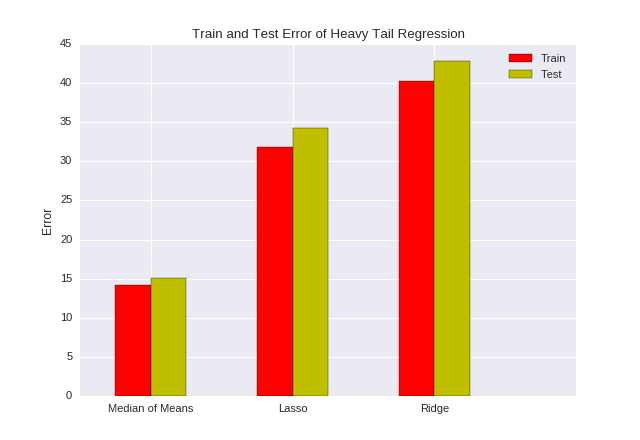

In [394]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
train_error = (14.14, 31.86, 40.23)

ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, train_error, width, color='r')

test_error = (15.03, 34.27, 42.83)
rects2 = ax.bar(ind+width, test_error, width, color='y')

# add some
ax.set_ylabel('Error')
plt.xlim(-width,len(ind)+width)
ax.set_title('Train and Test Error of Heavy Tail Regression')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Median of Means', 'Lasso', 'Ridge') )

ax.legend( (rects1[0], rects2[0]), ('Train', 'Test') )

plt.show()